## Лабораторная работа №2 Оптимизация модели

### Сегментатор растений

In [73]:
! pip install tensorflow-model-optimization
! pip install tf-keras
! pip install keras-preprocessing

import os
import random
import tf2onnx
from keras_preprocessing.image import load_img, img_to_array
import numpy as np
from sklearn.metrics import jaccard_score, f1_score
from sklearn.model_selection import train_test_split
import tensorflow_model_optimization as tfmot
import matplotlib.pyplot as plt
import tf_keras as keras


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [74]:
image_folder = 'data/images'
mask_folder = 'data/masks'

image_filenames = os.listdir(image_folder)
image_filenames.sort()
mask_filenames = os.listdir(mask_folder)
mask_filenames.sort()

IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 16
EPOCHS = 10

def load_images_and_masks(image_dir, mask_dir, img_height, img_width):
    images = []
    masks = []

    for image_name in os.listdir(image_dir):
        img_path = os.path.join(image_dir, image_name)
        img = load_img(img_path, target_size=(img_height, img_width))
        img = img_to_array(img) / 255.0
        images.append(img)

        mask_path = os.path.join(mask_dir, image_name)
        mask = load_img(mask_path, target_size=(img_height, img_width), color_mode="grayscale")
        mask = img_to_array(mask) / 255.0
        masks.append(mask)

    return np.array(images), np.array(masks)

In [75]:
images, masks = load_images_and_masks(image_folder, mask_folder, IMG_HEIGHT, IMG_WIDTH)

X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

In [76]:
def compute_metrics(y_true, y_pred):
    y_true = (y_true > 0.5).astype(np.uint8).flatten()
    y_pred = (y_pred > 0.5).astype(np.uint8).flatten()

    dice = f1_score(y_true, y_pred, average='binary')
    iou = jaccard_score(y_true, y_pred, average='binary')
    accuracy = np.mean(y_true == y_pred)

    return dice, iou, accuracy

In [77]:
def count_non_null_neurons(model):
    non_null_neurons = 0
    for layer in model.layers:
        if layer.get_weights():
            weights = layer.get_weights()[0]
            biases = layer.get_weights()[1]
            
            non_null_neurons += np.sum(weights != 0)
            non_null_neurons += np.sum(biases != 0)
    return non_null_neurons

In [78]:
def create_unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, 3)):
    inputs = keras.layers.Input(input_size)

    c1 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)

    u1 = keras.layers.UpSampling2D((2, 2))(c3)
    u1 = keras.layers.concatenate([u1, c2])
    c4 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    c4 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c4)

    u2 = keras.layers.UpSampling2D((2, 2))(c4)
    u2 = keras.layers.concatenate([u2, c1])
    c5 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    c5 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c5)

    outputs = keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c5)
    model = keras.Model(inputs, outputs)
    return model

Epoch 1/10
8/8 [==============================] - 72s 9s/step - loss: 0.3459 - accuracy: 0.9570 - val_loss: 0.1074 - val_accuracy: 0.9637
Epoch 2/10
8/8 [==============================] - 96s 12s/step - loss: 0.1012 - accuracy: 0.9638 - val_loss: 0.0912 - val_accuracy: 0.9637
Epoch 3/10
8/8 [==============================] - 84s 10s/step - loss: 0.0898 - accuracy: 0.9638 - val_loss: 0.0873 - val_accuracy: 0.9637
Epoch 4/10
8/8 [==============================] - 89s 11s/step - loss: 0.0852 - accuracy: 0.9638 - val_loss: 0.0856 - val_accuracy: 0.9637
Epoch 5/10
8/8 [==============================] - 91s 11s/step - loss: 0.0837 - accuracy: 0.9638 - val_loss: 0.0852 - val_accuracy: 0.9637
Epoch 6/10
8/8 [==============================] - 89s 11s/step - loss: 0.0847 - accuracy: 0.9638 - val_loss: 0.0862 - val_accuracy: 0.9637
Epoch 7/10
8/8 [==============================] - 92s 11s/step - loss: 0.0831 - accuracy: 0.9638 - val_loss: 0.0834 - val_accuracy: 0.9637
Epoch 8/10
8/8 [============

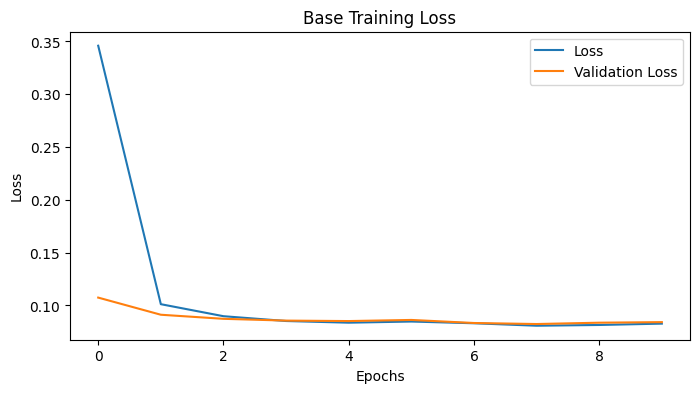

In [79]:
base_model = create_unet_model()

base_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

base_history = base_model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val)
)

y_pred = (base_model.predict(X_val) > 0.178).astype(np.uint8)
dice, iou, accuracy = compute_metrics(y_val, y_pred)
print(f"Dice: {dice}, IoU: {iou}, Accuracy: {accuracy}")

plt.figure(figsize=(8, 4))
plt.plot(base_history.history['loss'], label='Loss')
plt.plot(base_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Base Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [80]:
base_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_33 (Conv2D)          (None, 256, 256, 64)         1792      ['input_4[0][0]']             
                                                                                                  
 conv2d_34 (Conv2D)          (None, 256, 256, 64)         36928     ['conv2d_33[0][0]']           
                                                                                                  
 max_pooling2d_6 (MaxPoolin  (None, 128, 128, 64)         0         ['conv2d_34[0][0]']           
 g2D)                                                                                       

In [81]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
pruning_schedule = tfmot.sparsity.keras.PolynomialDecay(
    initial_sparsity=0.2,
    final_sparsity=0.8,
    begin_step=0,
    end_step=1000
)

pruned_model = prune_low_magnitude(base_model, pruning_schedule)

pruned_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    tfmot.sparsity.keras.PruningSummaries(log_dir='./logs')
]

In [82]:
pruned_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 prune_low_magnitude_conv2d  (None, 256, 256, 64)         3522      ['input_4[0][0]']             
 _33 (PruneLowMagnitude)                                                                          
                                                                                                  
 prune_low_magnitude_conv2d  (None, 256, 256, 64)         73794     ['prune_low_magnitude_conv2d_3
 _34 (PruneLowMagnitude)                                            3[0][0]']                     
                                                                                            

Epoch 1/10
8/8 [==============================] - 78s 10s/step - loss: 0.0941 - accuracy: 0.9638 - val_loss: 0.0825 - val_accuracy: 0.9637
Epoch 2/10
8/8 [==============================] - 90s 11s/step - loss: 0.0801 - accuracy: 0.9638 - val_loss: 0.0809 - val_accuracy: 0.9637
Epoch 3/10
8/8 [==============================] - 84s 10s/step - loss: 0.0790 - accuracy: 0.9638 - val_loss: 0.0801 - val_accuracy: 0.9637
Epoch 4/10
8/8 [==============================] - 100s 13s/step - loss: 0.0760 - accuracy: 0.9638 - val_loss: 0.0760 - val_accuracy: 0.9637
Epoch 5/10
8/8 [==============================] - 91s 11s/step - loss: 0.0732 - accuracy: 0.9638 - val_loss: 0.0741 - val_accuracy: 0.9637
Epoch 6/10
8/8 [==============================] - 114s 14s/step - loss: 0.0702 - accuracy: 0.9638 - val_loss: 0.0668 - val_accuracy: 0.9637
Epoch 7/10
8/8 [==============================] - 114s 14s/step - loss: 0.0643 - accuracy: 0.9638 - val_loss: 0.0581 - val_accuracy: 0.9637
Epoch 8/10
8/8 [========

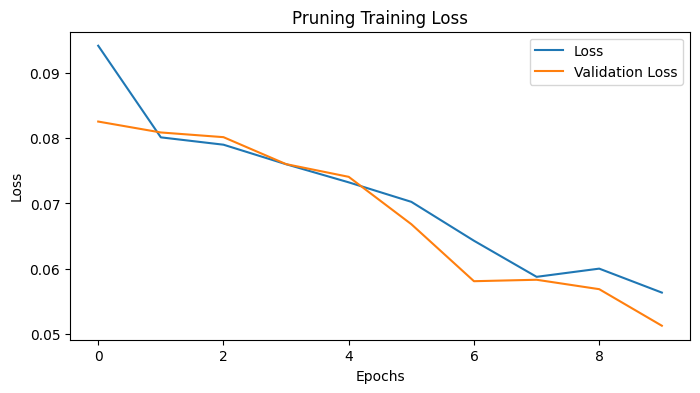

In [83]:
history = pruned_model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    callbacks=callbacks,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val)
)

final_model = tfmot.sparsity.keras.strip_pruning(pruned_model)

y_pred = (final_model.predict(X_val) > 0.178).astype(np.uint8)
dice, iou, accuracy = compute_metrics(y_val, y_pred)
print(f"Dice: {dice}, IoU: {iou}, Accuracy: {accuracy}")

plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Pruning Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

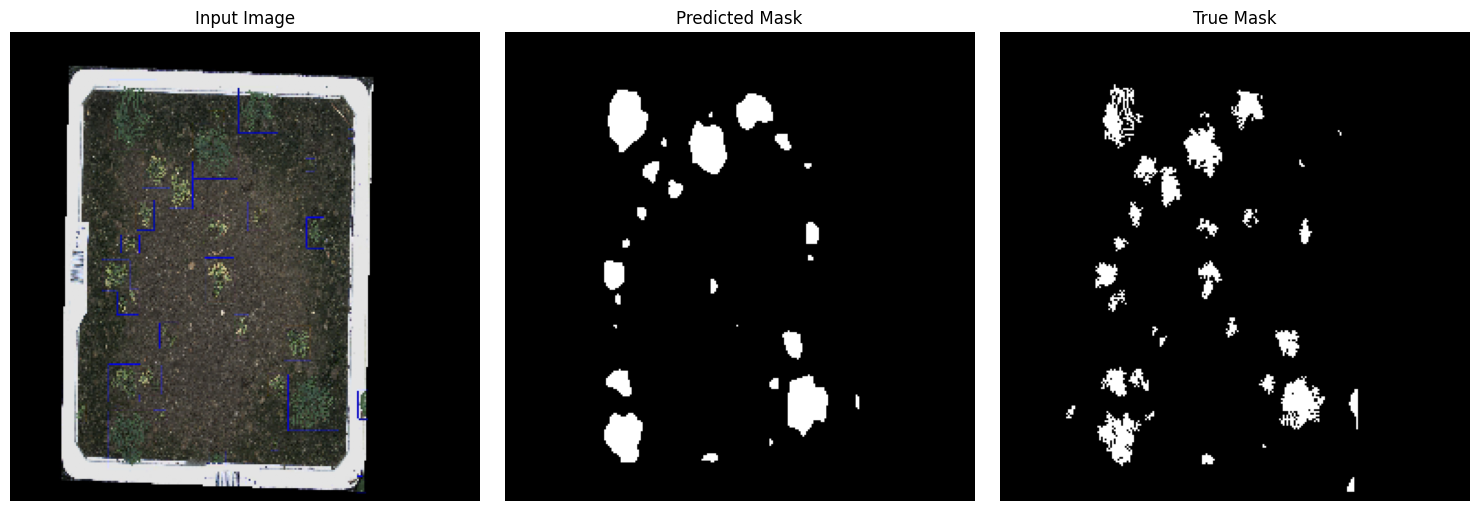

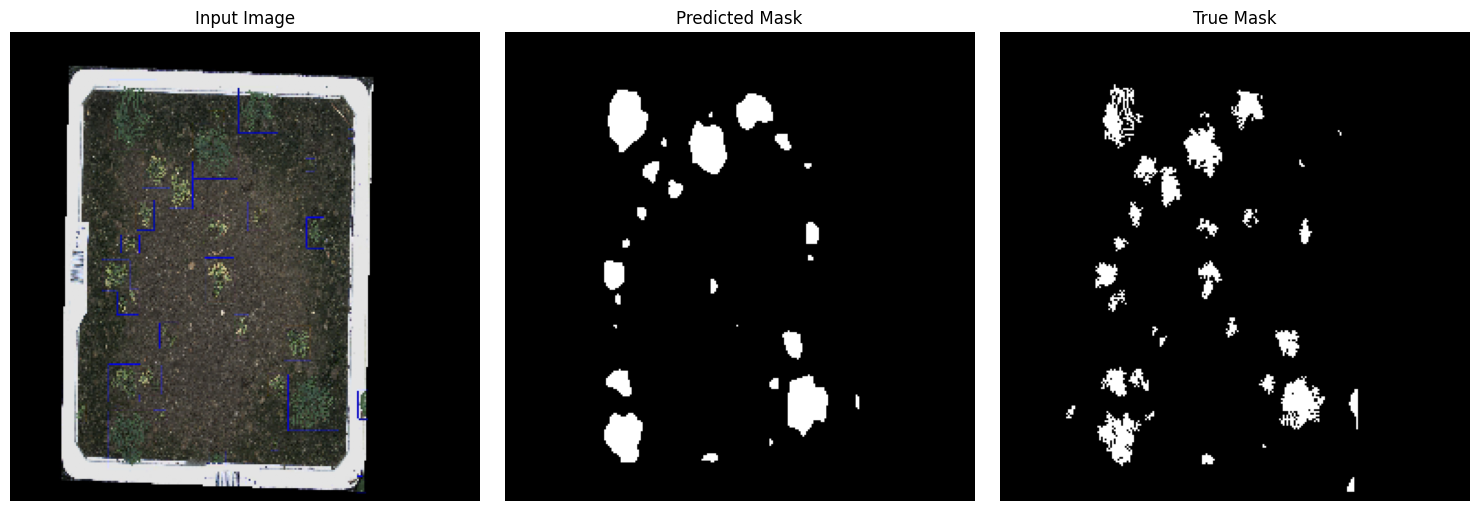

In [84]:
def visualize_prediction(model, index, X_data, y_data=None):
    
    input_image = X_data[index]
    input_image_expanded = np.expand_dims(input_image, axis=0)

    predicted_mask = model.predict(input_image_expanded, verbose=0)
    predicted_mask = predicted_mask.squeeze()

    threshold = 0.178
    predicted_binary_mask = (predicted_mask > threshold).astype(np.uint8)

    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(input_image.squeeze(), cmap='gray')
    plt.title("Input Image")
    plt.axis("off")
    
    plt.subplot(1, 3, 2)
    plt.imshow(predicted_binary_mask, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")
    
    if y_data is not None:
        true_mask = y_data[idx]
        plt.subplot(1, 3, 3)
        plt.imshow(true_mask.squeeze(), cmap='gray')
        plt.title("True Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

idx = random.randint(0, len(X_val) - 1)
visualize_prediction(base_model, idx, X_val, y_val)
visualize_prediction(final_model, idx, X_val, y_val)

In [87]:
import time

# Время предсказания для исходной модели
image = np.expand_dims(X_val[idx], axis=0)

start = time.time()
base_model.predict(image)
time_base = time.time() - start

# Время предсказания для обрезанной модели
start = time.time()
final_model.predict(image)
time_pruned = time.time() - start

print("Время предсказания исходной модели:", time_base, "секунд")
print("Время предсказания обрезанной модели:", time_pruned, "секунд")

1/1 [==============================] - 0s 160ms/step
Время предсказания исходной модели: 0.16750288009643555 секунд
Время предсказания обрезанной модели: 0.17182588577270508 секунд


In [92]:
non_null_count = count_non_null_neurons(base_model)
print(f"Number of non-null neurons in the base model: {non_null_count}")

non_null_count = count_non_null_neurons(pruned_model)
print(f"Number of non-null neurons in the pruned model: {non_null_count}")

Number of non-null neurons in the base model: 1883137
Number of non-null neurons in the pruned model: 1385988


In [ ]:
onnx_model, _ = tf2onnx.convert.from_keras(final_model, output_path="model.onnx")